In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
df = pd.read_csv("8-fraud_detection.csv")

In [69]:
df.columns # ne kadarlık alışveriş ve alışveriş risk score, dolandırıcılık mı?

Index(['transaction_amount', 'transaction_risk_score', 'is_fraud'], dtype='object')

In [70]:
df.head()

,transaction_amount,transaction_risk_score,is_fraud
0,1.879910,-1.485035,0
1,0.377083,-2.238585,0
2,1.354312,-2.664638,0
3,-0.509843,-1.502950,0
4,0.863561,-1.906364,0


In [71]:
df['is_fraud'].unique()

array([0, 1])

In [72]:
df['is_fraud'].value_counts()

is_fraud
0    9846
1     154
Name: count, dtype: int64

In [73]:
#imbalanced dataset

In [74]:
df.isnull().sum()

transaction_amount        0
transaction_risk_score    0
is_fraud                  0
dtype: int64

In [75]:
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

<Axes: xlabel='transaction_amount', ylabel='transaction_risk_score'>

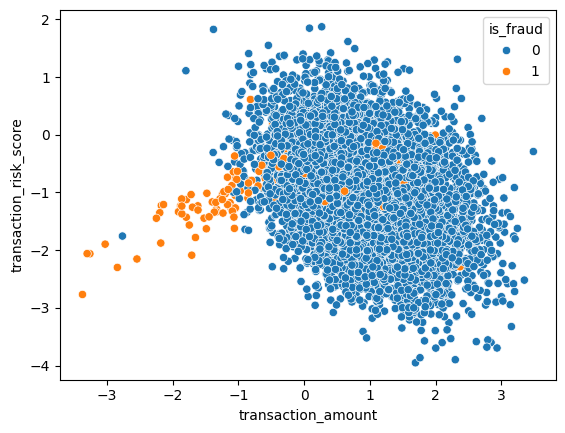

In [76]:
sns.scatterplot(x = X["transaction_amount"], y = X["transaction_risk_score"], hue=y)

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.25,random_state=15)

In [79]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [80]:
penalty = ["l1","l2","elasticnet"]
c_values = [100, 10, 1.0, 0.1, 0.01]
solver = ["newton-cg","lgfgs","liblinear","sag","saga","newton-cholesky"]
class_weight = [{0:w, 1:y} for w in [1,10,50,100] for y in [1,10,50,100]] # sınıfa tek tek ağırlık vererek dener

In [81]:
class_weight

[{0: 1, 1: 1},
 {0: 1, 1: 10},
 {0: 1, 1: 50},
 {0: 1, 1: 100},
 {0: 10, 1: 1},
 {0: 10, 1: 10},
 {0: 10, 1: 50},
 {0: 10, 1: 100},
 {0: 50, 1: 1},
 {0: 50, 1: 10},
 {0: 50, 1: 50},
 {0: 50, 1: 100},
 {0: 100, 1: 1},
 {0: 100, 1: 10},
 {0: 100, 1: 50},
 {0: 100, 1: 100}]

In [82]:
params = dict(penalty=penalty, C=c_values, solver=solver, class_weight= class_weight)

In [83]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [84]:
cv = StratifiedKFold()

In [85]:
grid = GridSearchCV(estimator= model, param_grid= params, scoring="accuracy", cv=cv)

In [86]:
import warnings
warnings.filterwarnings("ignore") # hata mesajlarını gizler

In [87]:
grid.fit(X_train, y_train)

,estimator,LogisticRegression()
,param_grid,"{'C': [100, 10, ...], 'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 10}, ...], 'penalty': ['l1', 'l2', ...], 'solver': ['newton-cg', 'lgfgs', ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


In [88]:
y_pred = grid.predict(X_test)

In [89]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(7500,))

In [90]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [91]:
score = accuracy_score(y_pred, y_test)
print("Score: ",score)
print(classification_report(y_pred, y_test))
print("confusion matrix: \n", confusion_matrix(y_pred,y_test))

Score:  0.9885333333333334
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7444
           1       0.38      0.82      0.52        56

    accuracy                           0.99      7500
   macro avg       0.69      0.91      0.76      7500
weighted avg       0.99      0.99      0.99      7500

confusion matrix: 
 [[7368   76]
 [  10   46]]


In [92]:
grid.best_params_

{'C': 100,
 'class_weight': {0: 10, 1: 50},
 'penalty': 'l1',
 'solver': 'liblinear'}

2. ROC Eğrisi (Receiver Operating Characteristic)
Bu grafik, modelin farklı eşik değerlerinde (0.0'dan 1.0'a kadar) nasıl davrandığını çizer.

Grafiğin iki ekseni vardır:

Y Ekseni (True Positive Rate / Recall): Gerçek suçluların yüzde kaçını yakaladın? (Yüksek olması istenir).

X Ekseni (False Positive Rate): Masumların yüzde kaçını yanlışlıkla suçladın? (Düşük olması istenir).

Grafiğin Yorumu:

Modelin çizgisi sol üst köşeye ne kadar yakınsa o kadar iyidir.

Bu, "Çok az yanlış alarm vererek (Düşük FPR), suçluların çoğunu yakalıyorum (Yüksek TPR)" demektir.

3. AUC (Area Under the Curve) – "Eğri Altında Kalan Alan"
ROC bir şekildir (grafiktir), AUC ise bu şeklin altındaki alanın büyüklüğüdür (sayıdır). Bize modelin kalitesi hakkında tek bir puan verir.

In [93]:
# roc, auc

In [94]:
model_prob = grid.predict_proba(X_test) # olasılıkları verir

In [95]:
model_prob

array([[0.99709602, 0.00290398],
       [0.87206047, 0.12793953],
       [0.96141001, 0.03858999],
       ...,
       [0.99675832, 0.00324168],
       [0.95728495, 0.04271505],
       [0.99657019, 0.00342981]], shape=(7500, 2))

In [96]:
model_prob = model_prob[:,1]# probabilities for the positive (fraud) class

In [97]:
model_prob

array([0.00290398, 0.12793953, 0.03858999, ..., 0.00324168, 0.04271505,
       0.00342981], shape=(7500,))

In [98]:
from sklearn.metrics import roc_auc_score, roc_curve

In [99]:
model_auc = roc_auc_score(y_test, model_prob)

In [100]:
model_auc

0.7976505250434389

In [101]:
# model false positive rate
# model true positive rate
model_fpr, model_tpr, thresholds = roc_curve(y_test, model_prob)

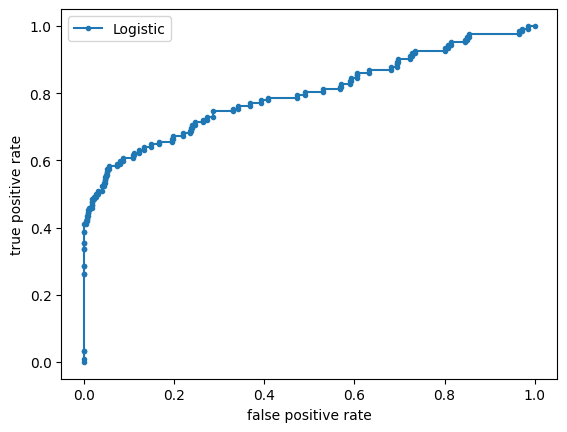

In [102]:
plt.plot(model_fpr, model_tpr, marker = ".", label = "Logistic")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend()

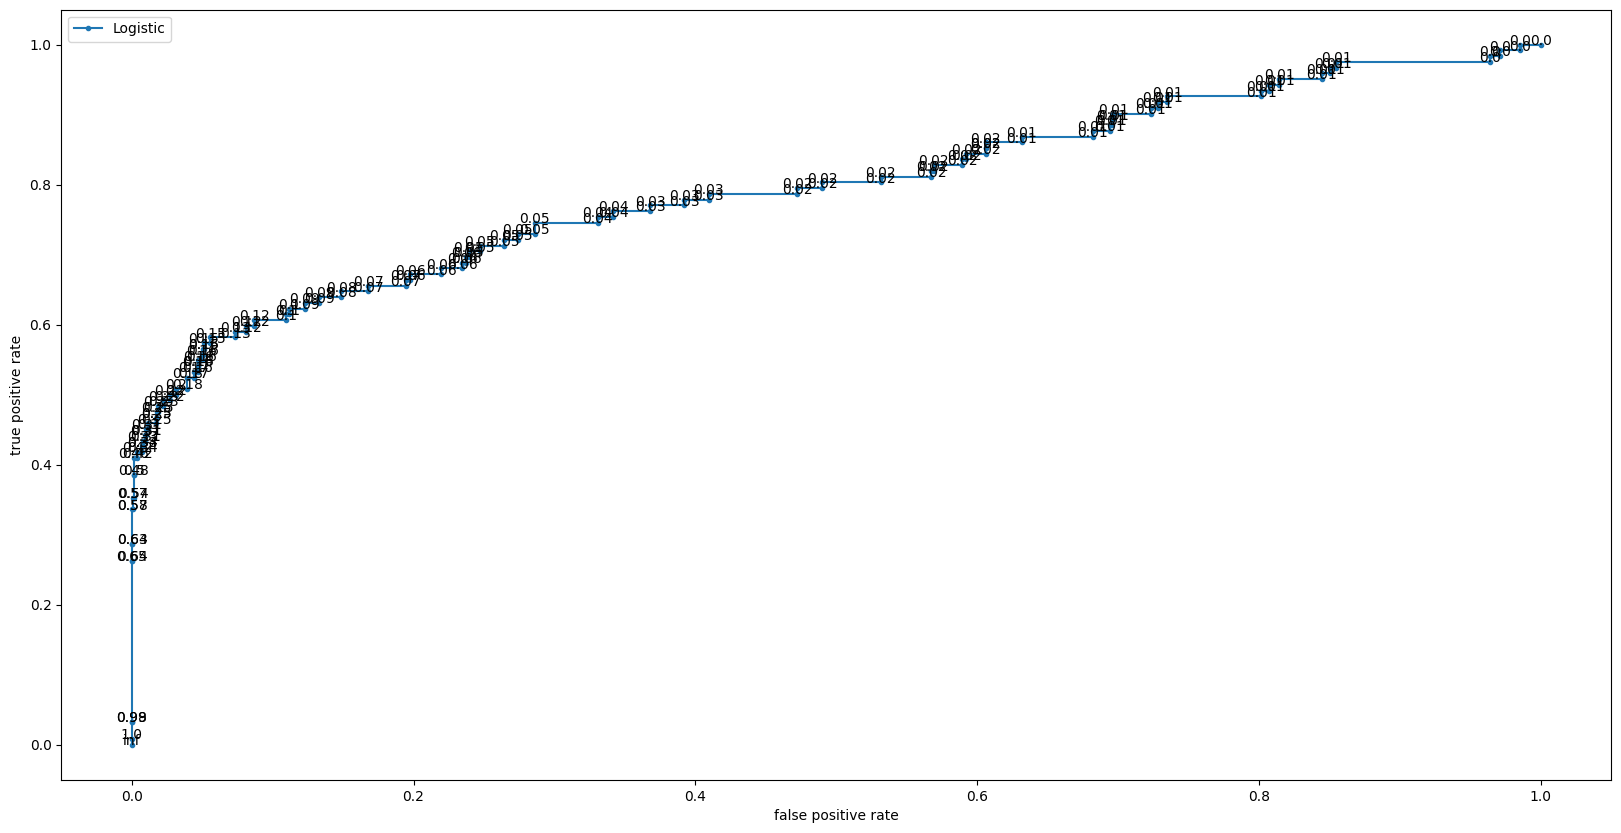

In [103]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(model_fpr, model_tpr, marker = ".", label = "Logistic")

for fpr, tpr, thresholds in zip(model_fpr, model_tpr, thresholds):
    ax.annotate(f"{np.round(thresholds, 2)}",(fpr,tpr),ha="center" )

ax.set_xlabel("false positive rate")
ax.set_ylabel("true positive rate")
ax.legend()

In [105]:
custom_threshold = 0.2

y_pred_custom = (model_prob >= custom_threshold).astype(int)

print(confusion_matrix(y_pred_custom, y_test))
print(classification_report(y_pred_custom,y_test))

[[7144   60]
 [ 234   62]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7204
           1       0.51      0.21      0.30       296

    accuracy                           0.96      7500
   macro avg       0.74      0.60      0.64      7500
weighted avg       0.95      0.96      0.95      7500

